# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.590346,False,0.451943
1,-0.623346,False,0.789491
2,0.639282,True,5.410539
3,1.780607,True,7.202585
4,0.450909,False,0.895143
...,...,...,...
995,-0.423072,True,4.448100
996,0.441852,False,1.227898
997,0.325917,False,0.960673
998,0.276323,False,0.783902


<AxesSubplot: xlabel='v0'>

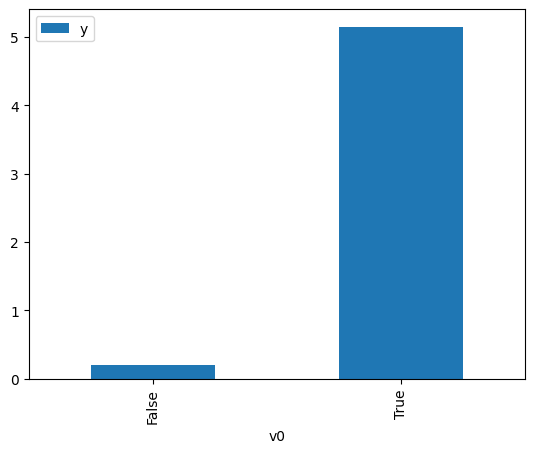

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

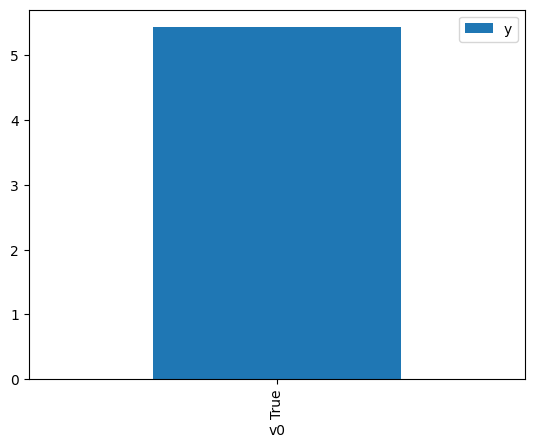

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.048491,False,0.280266,0.513315,1.948123
1,1.150179,False,2.729700,0.446180,2.241247
2,-0.503277,False,-0.300330,0.538791,1.856006
3,1.231618,False,4.399349,0.441662,2.264174
4,1.231618,False,4.399349,0.441662,2.264174
...,...,...,...,...,...
995,-0.808307,False,-3.695063,0.555775,1.799291
996,-0.339232,False,-0.438218,0.529618,1.888153
997,-1.494150,False,-3.072175,0.593431,1.685117
998,-0.665784,False,-0.738764,0.547853,1.825307


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.267147,True,7.415935,0.504416,1.982490
1,0.289825,True,6.490655,0.505690,1.977495
2,-0.546687,True,2.620579,0.458785,2.179670
3,-0.080909,True,3.477549,0.484866,2.062427
4,-2.306137,True,0.628236,0.363397,2.751811
...,...,...,...,...,...
995,1.761640,True,7.735308,0.587475,1.702201
996,0.290613,True,5.484001,0.505735,1.977322
997,0.712704,True,6.426136,0.529416,1.888874
998,-0.595939,True,4.719589,0.456038,2.192800


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8841.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:01:30   Log-Likelihood:                         -1426.1
No. Observations:                1000   AIC:                                      2856.
Df Residuals:                     998   BIC:                                      2866.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8407      0.031     58.699      0.000       1.779       1.902
x2             5.0481      0.046    110.258      0.000       4.958       5.138
==============================================================================
Omnibus:                        2.137   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                2.208
Skew:                           0.100   Prob(JB):                        0.332
Kurtosis:                       2.885   Cond. No.                         1.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""